# SMS Text Classification

Create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

Create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

Data from [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/).


In [ ]:
#try:
  # %tensorflow_version only exists in Colab.
#  !pip install tf-nightly
#except Exception:
#  pass

In [52]:
# import libraries
import tensorflow as tf
import pandas as pd
from tensorflow import keras
#!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

print(tf.__version__)

2.5.0


In [53]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "data/train-data.tsv"
test_file_path = "data/valid-data.tsv"

--2021-06-29 17:23:59--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 2606:4700:20::681a:321, 2606:4700:20::681a:221, 2606:4700:20::ac43:4695, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|2606:4700:20::681a:321|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv.1’

train-data.tsv.1    100%[===================>] 349.84K  --.-KB/s    in 0.04s   

2021-06-29 17:23:59 (7.75 MB/s) - ‘train-data.tsv.1’ saved [358233/358233]

--2021-06-29 17:23:59--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 2606:4700:20::681a:321, 2606:4700:20::681a:221, 2606:4700:20::ac43:4695, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|2606:4700:20::681a:321|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/

In [54]:
# load data files
train_file = pd.read_csv(train_file_path, sep='\t', names=["Class", "Message"])
test_file = pd.read_csv(test_file_path, sep='\t', names=["Class", "Message"])

The file is tab separated (\t) and I provide column names "Class" and "Message".

# Exploratory Data Analysis 

In [55]:
train_file.describe()

,Class,Message
count,4179,4179
unique,2,3935
top,ham,"sorry, i'll call later"
freq,3619,22


There are two unique classes: "ham" and "spam". There are less unique messages (3935) than total message count (4179) indicating some repeated messages.
The top class is "ham" and the top message is "sorry, i'll call later".

In [56]:
train_file.groupby("Class").describe().T

Class                              ham  \
Message count                     3619   
        unique                    3430   
        top     sorry, i'll call later   
        freq                        22   

Class                                                        spam  
Message count                                                 560  
        unique                                                505  
        top     hmv bonus special 500 pounds of genuine hmv vo...  
        freq                                                    3

There are 3619 ham compared to 560 spam messages. This means the data is imbalanced. The most popular ham message "sorry, i'll call later" occured 22 times. Whereas the most popular spam message "hmv bonus special 500 pounds of genuine hmv..." occured 3 times.

## Wordcloud
Wordcloud allows us to visualize the most frequent words in the given text.

In [57]:
# Get all the ham and spam emails
train_ham = train_file[train_file.Class =='ham']
train_spam = train_file[train_file.Class =='spam']
# Create numpy list to visualize using wordcloud
train_ham_text = " ".join(train_ham.Message.to_numpy().tolist())
train_spam_text = " ".join(train_spam.Message.to_numpy().tolist())

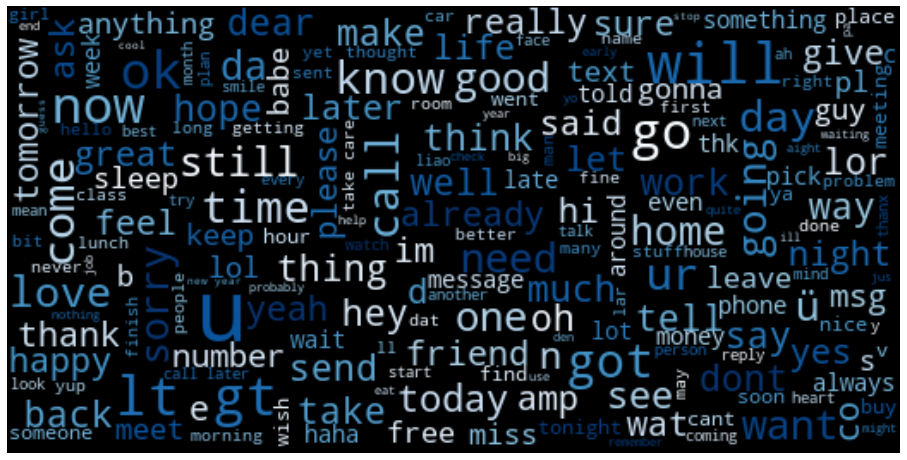

In [58]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width=520, height=260, stopwords=STOPWORDS, max_font_size=50, 
                          background_color="black", colormap='Blues').generate(train_ham_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

The ham message WordCloud shows that "love", "going", "come", "home", etc. are the most commonly appeared words in ham messages.

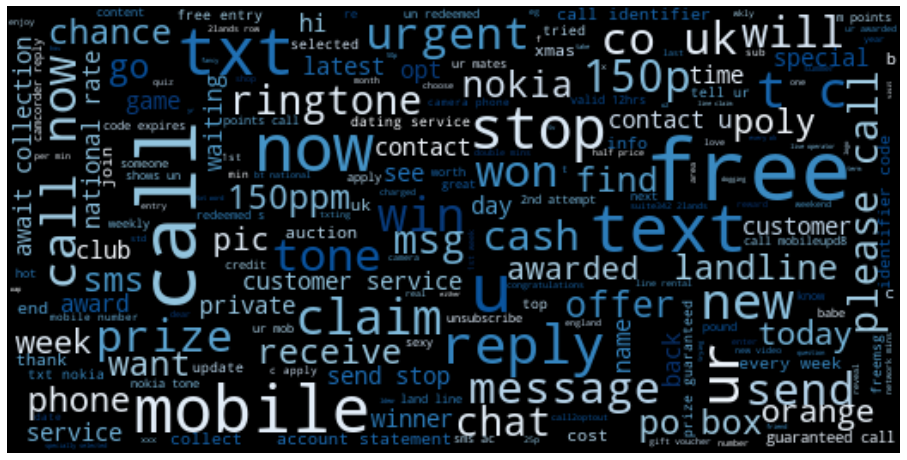

In [59]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width=520, height=260, stopwords=STOPWORDS, max_font_size=50, 
                           background_color="black", colormap='Blues').generate(train_spam_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

The spam message WordCloud shows that "free", "text", "call" etc. are the most commonly appeared words in spam messages.

# Data Processing

## Data Imbalance

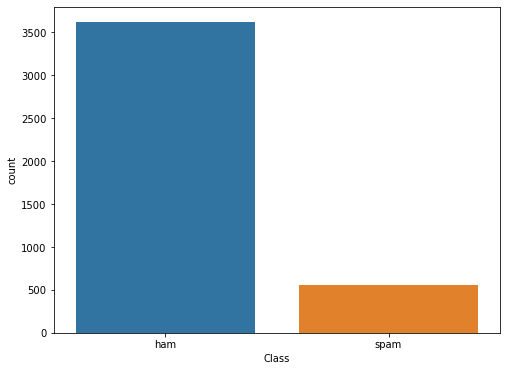

In [60]:
# Percentage of spam messages
len(train_spam)/len(train_ham)*100 # 15.48%

# Countplot showing imbalance data
plt.figure(figsize=(8,6))
sns.countplot(x="Class", data=train_file)
plt.show()

The bar chart shows that the classes are imbalanced. 85% of the messages are ham.

### Downsampling
To handle the imbalance data, we downsample.
Downsampling randomly deletes some of the observations from the majority class so that the numbers in majority and minority classes are matched.

In [61]:
# Downsample the ham msg for train
train_ham_df = train_ham.sample(n = len(train_spam), random_state = 44)
train_spam_df = train_spam
print(train_ham_df.shape, train_spam_df.shape)
train_df = train_ham_df.append(train_spam_df).reset_index(drop=True)

(560, 2) (560, 2)


In [62]:
# Downsample for test file
test_ham = test_file[test_file.Class =='ham']
test_spam = test_file[test_file.Class =='spam']

# Downsample the ham msg for test
test_ham_df = test_ham.sample(n = len(test_spam), random_state = 44)
test_spam_df = test_spam
print(test_ham_df.shape, test_spam_df.shape)
test_df = test_ham_df.append(test_spam_df).reset_index(drop=True)

(187, 2) (187, 2)


## Test train split

In [63]:
# Map ham label as 0 and spam as 1
train_df['msg_type']= train_df['Class'].map({'ham': 0, 'spam': 1})
test_df['msg_type']= test_df['Class'].map({'ham': 0, 'spam': 1})


train_msg = train_df['Message']
train_labels = train_df['msg_type'].values
test_msg = test_df['Message']
test_labels = test_df['msg_type'].values

## Tokenization
Tokenizer API from TensorFlow Keras splits sentences into words and encodes them into integers.
- Tokenize into words
- Filter out punctuation and rare words
- Convert all words to lower case and to integer index

In [64]:
# Defining tokenizer hyperparameters
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

In [65]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [66]:
# Get the word_index 
word_index = tokenizer.word_index
# How many words 
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 3999 unique tokens in training data. 


## Sequencing and Padding
Use texts_tosequences() to espresent each sentence by sequences of numbers from tokenizer object.

Use pad_sequences() so that each sequences have the same length.


In [67]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type)
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
                                padding = padding_type, truncating = trunc_type)

In [68]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1120, 50)
Shape of testing tensor:  (374, 50)


# Dense Spam Detection Model
Train model using a Dense architecture followed by LSTM and Bi-LSTM.

In [69]:
# hyper-parameters
vocab_size = 500 
embeding_dim = 16
drop_value = 0.2 
n_dense = 24

In [70]:
# Dense model architecture
dense_model = Sequential()
dense_model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
dense_model.add(GlobalAveragePooling1D())
dense_model.add(Dense(24, activation='relu'))
dense_model.add(Dropout(drop_value))
dense_model.add(Dense(1, activation='sigmoid'))

In [71]:
dense_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [72]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = dense_model.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels), 
                    callbacks =[early_stop], verbose=2)

Epoch 1/30
35/35 - 1s - loss: 0.6908 - accuracy: 0.6402 - val_loss: 0.6856 - val_accuracy: 0.8930
Epoch 2/30
35/35 - 0s - loss: 0.6774 - accuracy: 0.8509 - val_loss: 0.6660 - val_accuracy: 0.8797
Epoch 3/30
35/35 - 0s - loss: 0.6462 - accuracy: 0.8643 - val_loss: 0.6195 - val_accuracy: 0.8824
Epoch 4/30
35/35 - 0s - loss: 0.5860 - accuracy: 0.8795 - val_loss: 0.5426 - val_accuracy: 0.8850
Epoch 5/30
35/35 - 0s - loss: 0.4956 - accuracy: 0.8866 - val_loss: 0.4491 - val_accuracy: 0.8850
Epoch 6/30
35/35 - 0s - loss: 0.4014 - accuracy: 0.8964 - val_loss: 0.3675 - val_accuracy: 0.8904
Epoch 7/30
35/35 - 0s - loss: 0.3317 - accuracy: 0.9071 - val_loss: 0.3086 - val_accuracy: 0.8957
Epoch 8/30
35/35 - 0s - loss: 0.2757 - accuracy: 0.9232 - val_loss: 0.2649 - val_accuracy: 0.9037
Epoch 9/30
35/35 - 0s - loss: 0.2321 - accuracy: 0.9250 - val_loss: 0.2322 - val_accuracy: 0.9091
Epoch 10/30
35/35 - 0s - loss: 0.2086 - accuracy: 0.9348 - val_loss: 0.2063 - val_accuracy: 0.9091
Epoch 11/30
35/35 -

In [73]:
# Model performance on test data 
dense_model.evaluate(testing_padded, test_labels)

12/12 [==============================] - 0s 1ms/step - loss: 0.1004 - accuracy: 0.9679


[0.10039439797401428, 0.9679144620895386]

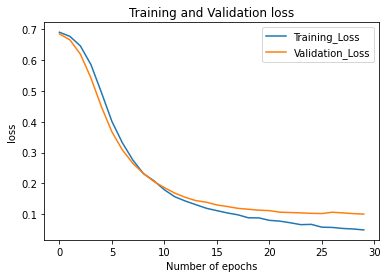

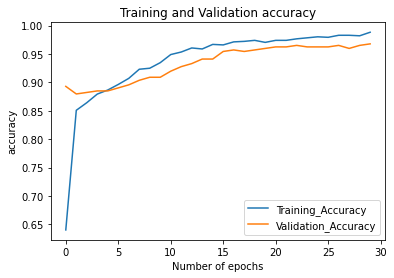

In [74]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_dense(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

plot_dense('Training_Loss', 'Validation_Loss', 'loss')
plot_dense('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

# Long Short Term Memory (LSTM) Model
This neural network is capable of learning order dependence in sequence prediction problems.

In [75]:
# LSTM hyperparameters
n_lstm = 20
drop_lstm =0.2

In [76]:
# LSTM Spam detection architecture
LSTM_model = Sequential()
LSTM_model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
LSTM_model.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
LSTM_model.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
LSTM_model.add(Dense(1, activation='sigmoid'))

In [77]:
LSTM_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [78]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = LSTM_model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
35/35 - 6s - loss: 0.6702 - accuracy: 0.6314 - val_loss: 0.5994 - val_accuracy: 0.6718
Epoch 2/30
35/35 - 1s - loss: 0.4182 - accuracy: 0.8101 - val_loss: 0.3157 - val_accuracy: 0.8925
Epoch 3/30
35/35 - 1s - loss: 0.2488 - accuracy: 0.9217 - val_loss: 0.2534 - val_accuracy: 0.9160
Epoch 4/30
35/35 - 1s - loss: 0.2087 - accuracy: 0.9367 - val_loss: 0.2226 - val_accuracy: 0.9225
Epoch 5/30
35/35 - 1s - loss: 0.1777 - accuracy: 0.9455 - val_loss: 0.2096 - val_accuracy: 0.9281
Epoch 6/30
35/35 - 1s - loss: 0.1617 - accuracy: 0.9500 - val_loss: 0.2252 - val_accuracy: 0.9212
Epoch 7/30
35/35 - 1s - loss: 0.1414 - accuracy: 0.9565 - val_loss: 0.2003 - val_accuracy: 0.9306
Epoch 8/30
35/35 - 1s - loss: 0.1343 - accuracy: 0.9565 - val_loss: 0.2027 - val_accuracy: 0.9301
Epoch 9/30
35/35 - 1s - loss: 0.1310 - accuracy: 0.9592 - val_loss: 0.2207 - val_accuracy: 0.9261


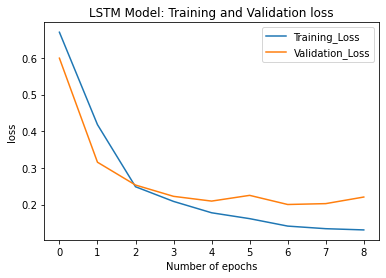

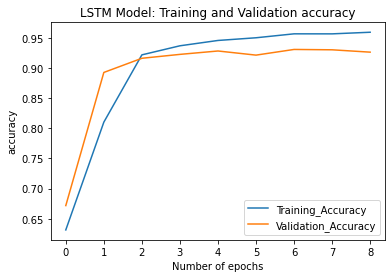

In [79]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_LSTM(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
plot_LSTM('Training_Loss', 'Validation_Loss', 'loss')
plot_LSTM('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

# Bi-directional Long Short Term Memory (BiLSTM) Model
Bi-LSTM learns patterns from before and after a given token. 

In [80]:
# Biderectional LSTM Spam detection architecture
biLSTM_model = Sequential()
biLSTM_model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
biLSTM_model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
biLSTM_model.add(Dense(1, activation='sigmoid'))

In [81]:
biLSTM_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [82]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = biLSTM_model.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
35/35 - 4s - loss: 0.6803 - accuracy: 0.6187 - val_loss: 0.6435 - val_accuracy: 0.6728
Epoch 2/30
35/35 - 1s - loss: 0.4753 - accuracy: 0.8128 - val_loss: 0.3273 - val_accuracy: 0.8950
Epoch 3/30
35/35 - 1s - loss: 0.2314 - accuracy: 0.9363 - val_loss: 0.2391 - val_accuracy: 0.9226
Epoch 4/30
35/35 - 1s - loss: 0.1634 - accuracy: 0.9526 - val_loss: 0.1641 - val_accuracy: 0.9502
Epoch 5/30
35/35 - 1s - loss: 0.1339 - accuracy: 0.9631 - val_loss: 0.1405 - val_accuracy: 0.9593
Epoch 6/30
35/35 - 1s - loss: 0.1075 - accuracy: 0.9722 - val_loss: 0.1463 - val_accuracy: 0.9569
Epoch 7/30
35/35 - 1s - loss: 0.0946 - accuracy: 0.9747 - val_loss: 0.1300 - val_accuracy: 0.9618
Epoch 8/30
35/35 - 0s - loss: 0.0850 - accuracy: 0.9768 - val_loss: 0.1157 - val_accuracy: 0.9648
Epoch 9/30
35/35 - 0s - loss: 0.0746 - accuracy: 0.9819 - val_loss: 0.1226 - val_accuracy: 0.9645
Epoch 10/30
35/35 - 1s - loss: 0.0760 - accuracy: 0.9783 - val_loss: 0.1277 - val_accuracy: 0.9630


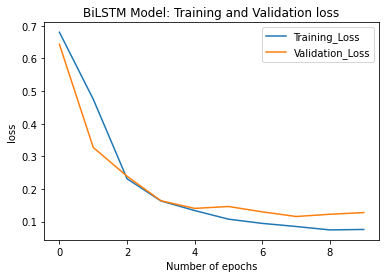

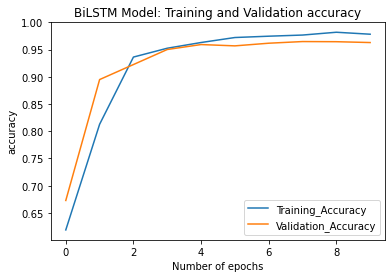

In [83]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_biLSTM(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
# Plot
plot_biLSTM('Training_Loss', 'Validation_Loss', 'loss')
plot_biLSTM('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

# Choose Model

In [84]:
# Comparing three different models
print(f"Dense architecture loss and accuracy: {dense_model.evaluate(testing_padded, test_labels)} " )
print(f"LSTM architecture loss and accuracy: {LSTM_model.evaluate(testing_padded, test_labels)} " )
print(f"Bi-LSTM architecture loss and accuracy: {biLSTM_model.evaluate(testing_padded, test_labels)} " )

12/12 [==============================] - 0s 1ms/step - loss: 0.1004 - accuracy: 0.9679
Dense architecture loss and accuracy: [0.10039439797401428, 0.9679144620895386] 
12/12 [==============================] - 0s 7ms/step - loss: 0.2207 - accuracy: 0.9261
LSTM architecture loss and accuracy: [0.22065313160419464, 0.9261497259140015] 
12/12 [==============================] - 0s 5ms/step - loss: 0.1277 - accuracy: 0.9630
Bi-LSTM architecture loss and accuracy: [0.12772788107395172, 0.9629946351051331] 


Based on loss, accuracy and the plots above, we select the Dense architecture as the final model for classifying whether messages are spam or ham.

# Prediction

In [85]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    pred_text = [pred_text]
    new_seq = tokenizer.texts_to_sequences(pred_text)
    padded = pad_sequences(new_seq, maxlen=max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    prediction = (dense_model.predict(padded))[0][0]
    if prediction < 0.5:
        return [prediction, 'ham']
    else:
        return [prediction, 'spam']
pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

[0.0045603514, 'ham']


In [86]:
# Run this cell to test your function and model. 
def test_predictions():
    test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

    test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
    passed = True

    for msg, ans in zip(test_messages, test_answers):
        prediction = predict_message(msg)
        if prediction[1] != ans:
            passed = False

    if passed:
        print("You passed the challenge. Great job!")
    else:
        print("You haven't passed yet. Keep trying.")

test_predictions()

You passed the challenge. Great job!
